<a href="https://colab.research.google.com/github/Dr-Doofensmirtz/my_projects/blob/master/data_science_bowl_2018/1_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# getting data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


downloading data from kaggle

In [7]:
KAGGLE_JSON = "./drive/MyDrive/kaggle/"
TRAIN_ZIP = "./stage1_train.zip"
RAW_DATA = "./train_data/"
IMG_PATH = glob.glob("./train_data/*/images/*.png")
MASK_PATH = glob.glob("./train_data/*/masks/")

NUMOF_FOLD = 5
CLASSES = ['nuclei']
DEVICE = 'cuda'
MODEL_SAVE_PATH = "./saved_model/"

#IMAGE PARAMETER
MEAN = np.array((0.485, 0.456, 0.406))
STD = np.array((0.229, 0.224, 0.225))
IMG_HEIGHT = 128
IMG_WIDTH = 128
IN_CHANNELS = 3

#HYPERPARAMETERS
LOSS = ''
METRICS = ''
OPTIMIZER = ''
BATCH_SIZE = ''
MODEL = ''
LR = ''
ENCODER = ''
ENCODER_WEIGHTS = ''
EPOCHS = ''

In [8]:
import os
try:
  os.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_JSON
except:
  print('path not found')

In [3]:
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/9.10M [00:00<?, ?B/s]
100% 9.10M/9.10M [00:00<00:00, 149MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 102MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 127MB/s]
 99% 273M/276M [00:01<00:00, 123MB/s]
100% 276M/276M [00:01<00:00, 147MB/s]
 82% 65.0M/79.1M [00:00<00:00, 136MB/s]
100% 79.1M/79.1M [00:00<00:00, 146MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.59MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 182MB/s]


extracting training data

In [4]:
import zipfile
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import shutil
import glob

from skimage.io import *
from skimage.transform import resize
from sklearn import model_selection

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn

import albumentations as A
from albumentations.pytorch import ToTensor

%matplotlib inline

In [5]:
with zipfile.ZipFile(TRAIN_ZIP, "r") as file:
  file.extractall(RAW_DATA)

In [9]:
def get_mask(mask_dir, IMG_HEIGHT, IMG_WIDTH):   
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    
    for mask_f in os.listdir(mask_dir):
        mask_ = imread(os.path.join(mask_dir, mask_f))
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    return mask

In [11]:
def get_folds(df, num_folds=5):

  df['kfold'] = -1
  df = df.sample(frac=1).reset_index(drop=True)
  kf = model_selection.KFold(n_splits=num_folds)

  for fold_, (_, x) in enumerate(kf.split(df)):
      for xs in x:
          df.loc[xs, "kfold"] = fold_

  return df

In [25]:
def format_image(img, mean, std):
    img = np.array(np.transpose(img, (1,2,0)))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

def viz(dataset, n=5):
  fig, ax = plt.subplots(n, 2,figsize=(n*5,n*5))

  for i in range(n):
    x ,y = dataset.__getitem__(np.random.randint(0,30))
    x = format_image(x, MEAN, STD)
    y = format_mask(y)
    ax[i, 0].imshow(x)
    ax[i, 1].imshow(y, interpolation="nearest", cmap="gray")

In [14]:
data = {"img_": IMG_PATH, "mask_": MASK_PATH}
df = pd.DataFrame(data=data)
df_fold = get_folds(df, NUMOF_FOLD)

In [15]:
def get_train_transform():
   return A.Compose(
       [
        A.Normalize(mean=MEAN, std=STD),
        A.Resize(IMG_HEIGHT,IMG_WIDTH),
        A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        ToTensor()
        ])
   
def get_valid_transform():
  return A.Compose([
                    A.Normalize(mean=MEAN, std=STD),
                    A.Resize(IMG_HEIGHT,IMG_WIDTH),
                    ToTensor()
  ])

In [16]:
class dataSet(Dataset):
  def __init__(self, df, fold=0, train=True, transforms= None):
    self.transforms = transforms

    if train:
      self.df = df[df.kfold != fold].reset_index(drop=True)
    else:
      self.df = df[df.kfold == fold].reset_index(drop=True)

  def __getitem__(self, idx):
    img_path = df.loc[idx, "img_"]
    mask_path = df.loc[idx, "mask_"]

    img = imread(img_path).astype('float32')
    img = img[:,:,:3]
    mask = get_mask(mask_path, img.shape[0], img.shape[1]).astype('float32')
    
    augmented = self.transforms(image=img, mask=mask)
    img = augmented['image']
    mask = augmented['mask']
    mask = mask[0].permute(2, 0, 1)
    return img,mask

  def __len__(self):
    return len(self.df)

In [17]:
train_dataset = dataSet(df_fold, fold=0, train=True, transforms= get_train_transform())
valid_dataset = dataSet(df_fold, fold=0, train=False, transforms = get_valid_transform())

In [18]:
x,y = valid_dataset[9]
x.shape
x = resize(x, (-1,3,256,256))
x.shape

(0, 3, 256, 256)

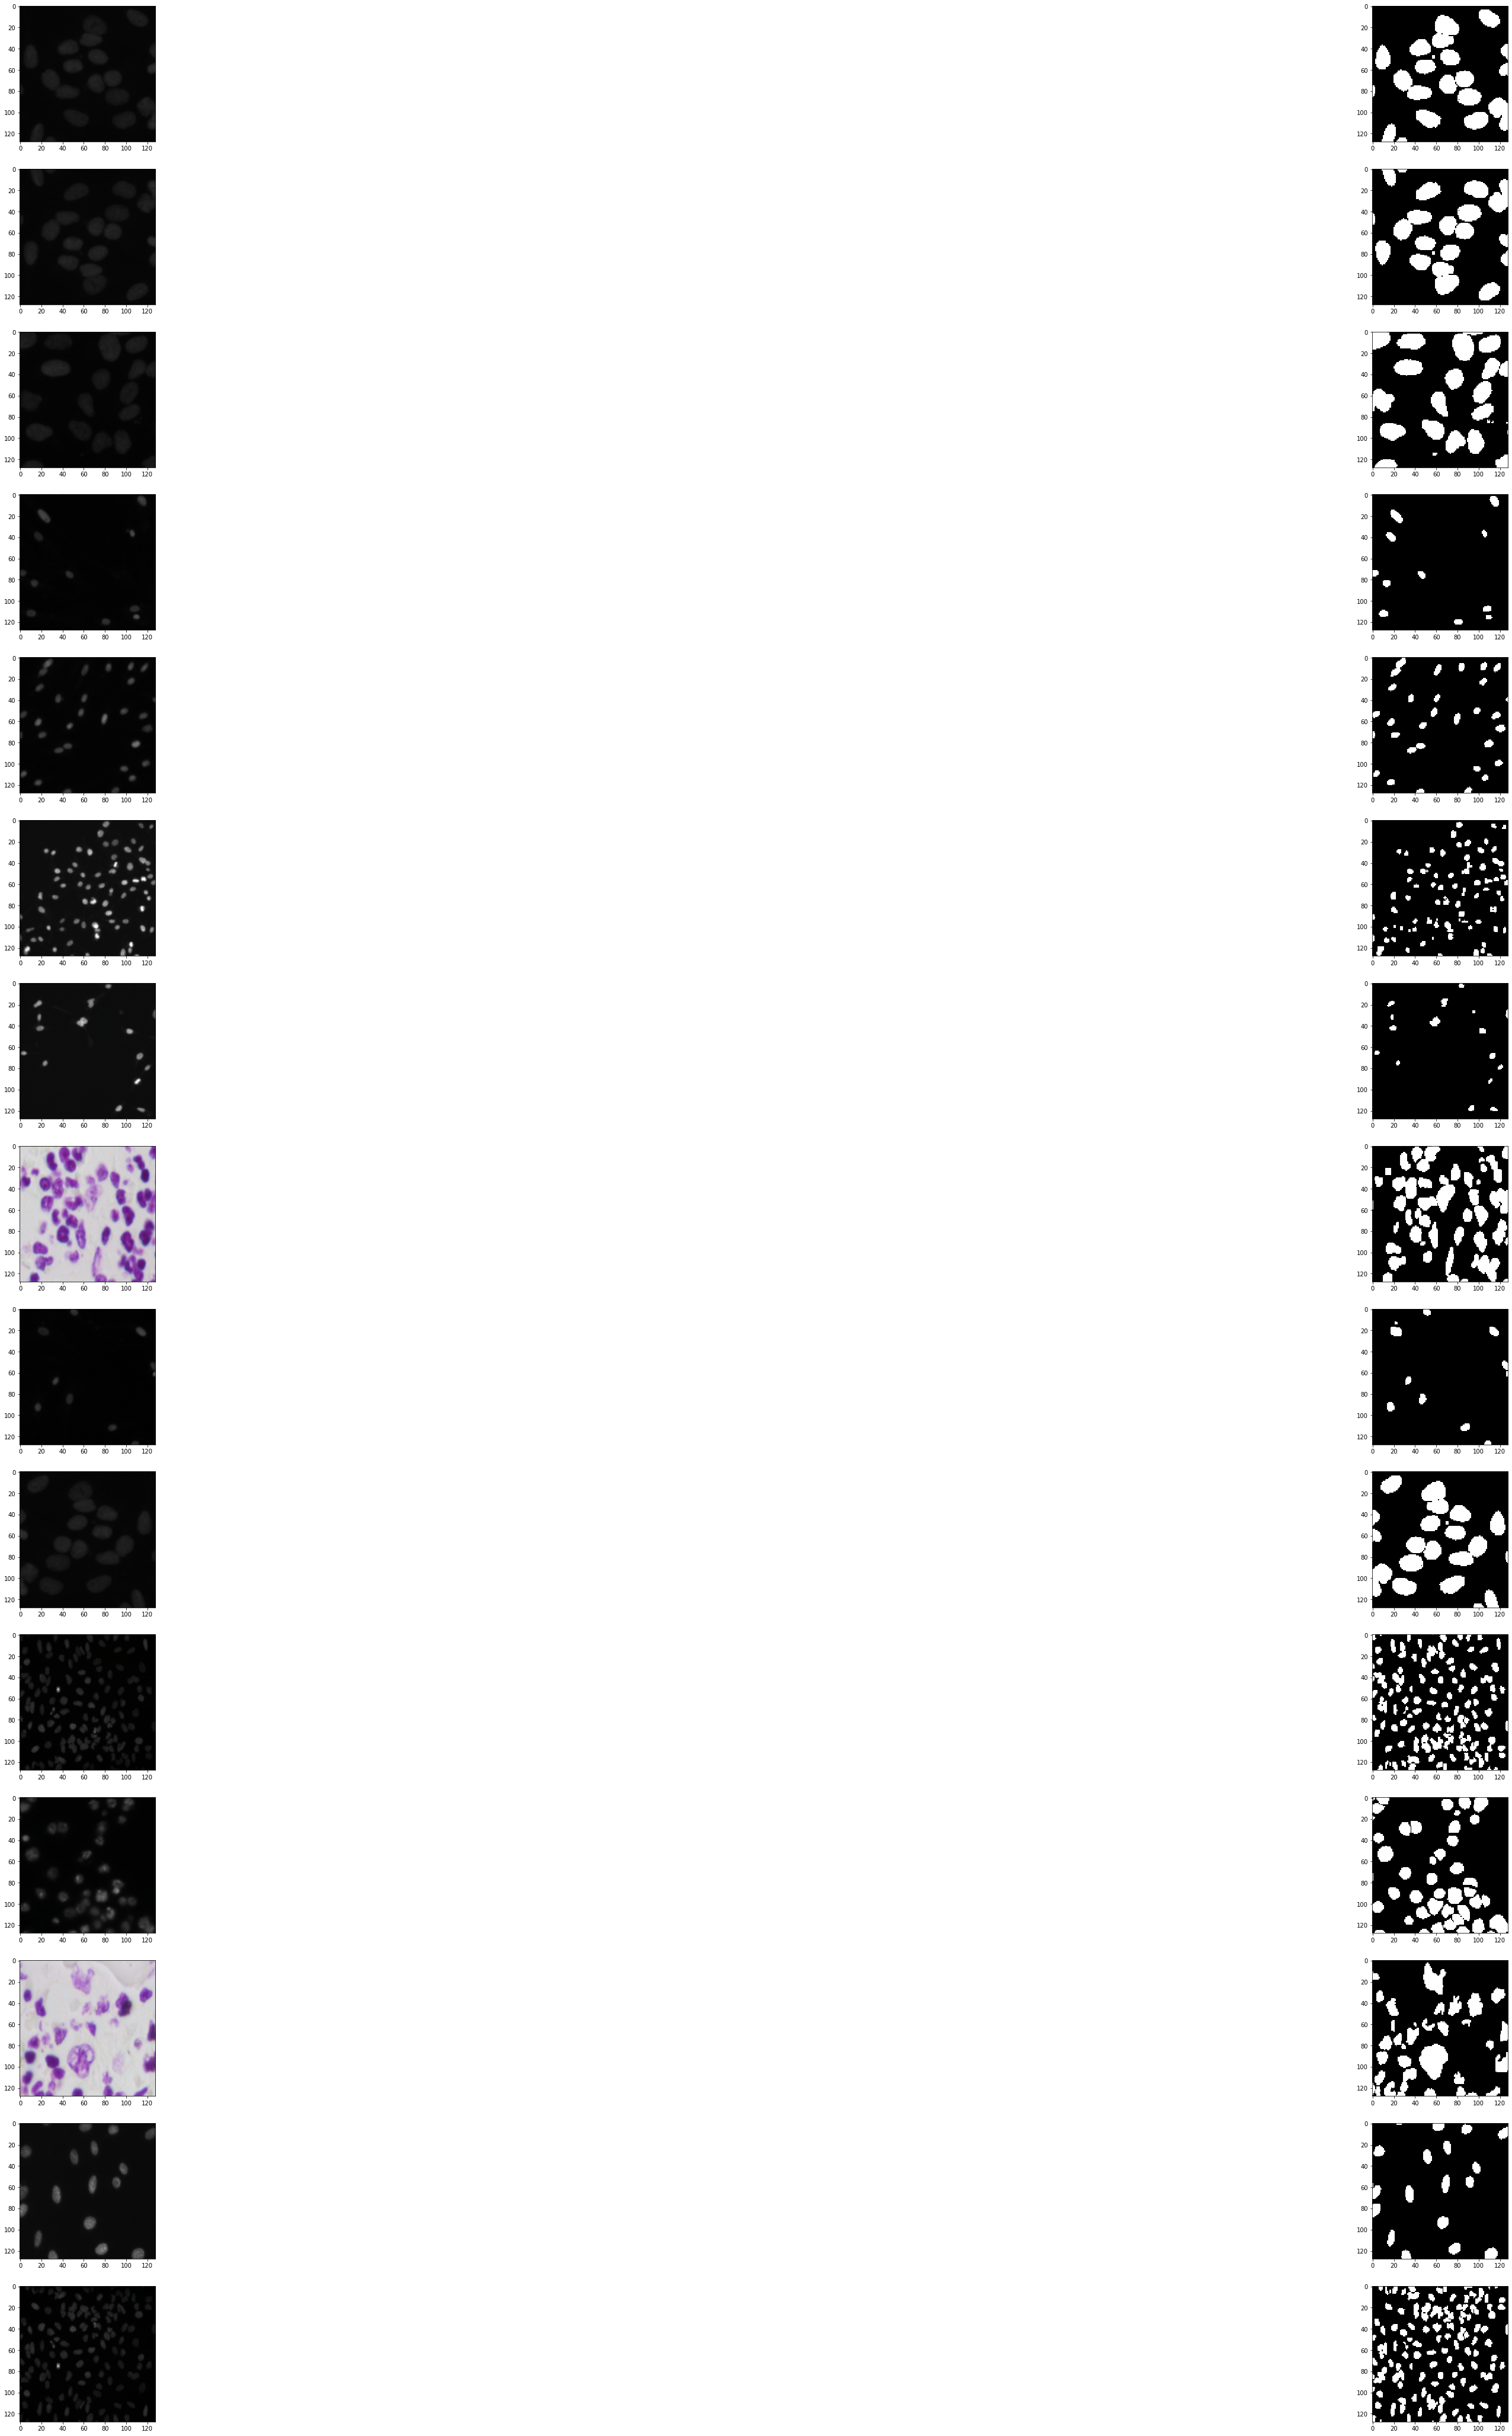

In [26]:
viz(train_dataset, 15)

# model 1


In [34]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-zlilzupl
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-zlilzupl
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 245kB 24.1MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.3-cp36-none-any.whl size=70451 sha256=5d36a2c434a43923c5022c15c4dad32446a19b1b272e8279d69f5b188febaa38
  Stored in directory: /tmp/pip-ephem-wheel-cache-dwzzjqno/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=5f9712ee79eceeb9295d9daea17a169782e2416473f1b5425f36907e7b78b328
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-no

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['cell']
DEVICE = 'cuda'

model = smp.Unet(encoder_name=ENCODER,
                 encoder_weights = ENCODER_WEIGHTS,
                 in_channels=3,
                 classes=len(CLASSES))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [39]:
train_dataloader = DataLoader(train_dataset, batch_size=8)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)

In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_dataloader)
    valid_logs = valid_epoch.run(valid_dataloader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it, dice_loss - -3.629, iou_score - 7.852]
Model saved!

Epoch: 1
train:  10%|█         | 7/67 [00:25<03:36,  3.61s/it, dice_loss - -3.487, iou_score - 9.299]


KeyboardInterrupt: ignored

In [ ]:
best_model = torch.load('./best_model.pth')

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(valid_dataloader)

valid: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it, dice_loss - -3.629, iou_score - 7.852]


In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

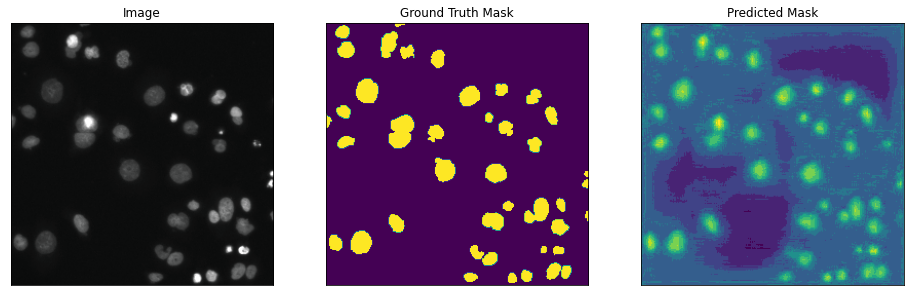

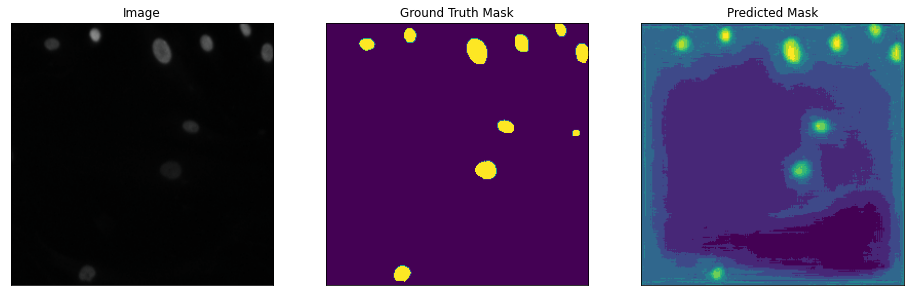

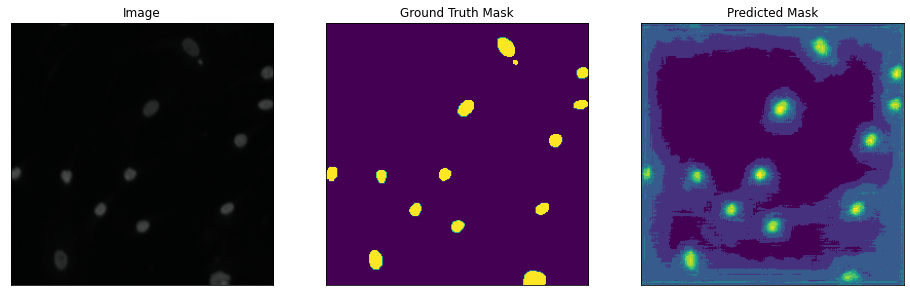

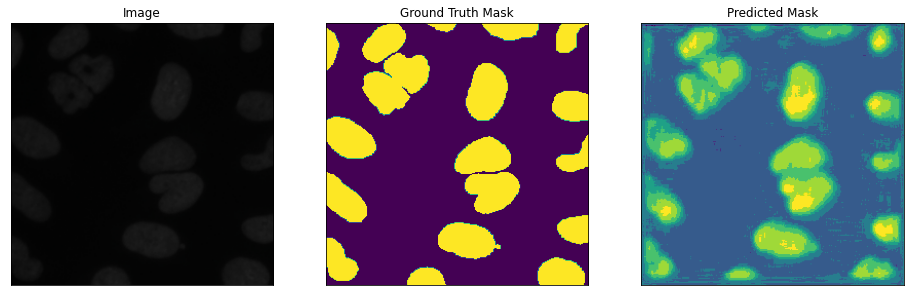

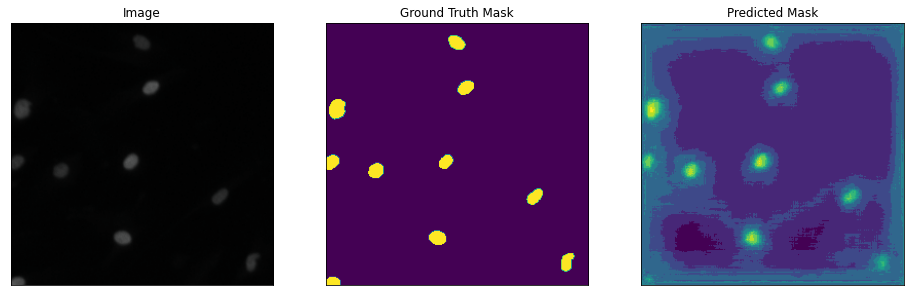

In [ ]:
for i in range(5):
    n = np.random.choice(len(valid_dataset))
    
    image, gt_mask = valid_dataset[n]

    image_vis = format_image(image)
    gt_mask = format_mask(gt_mask)
    
    x_tensor = image.cpu().unsqueeze(0)
    pr_mask = best_model.predict(x_tensor.to(DEVICE))
    pr_mask = pr_mask.squeeze().cpu().numpy().round()
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

# model 2

In [43]:
from tqdm.auto import tqdm as tq

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [28]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [ ]:
model = UNet(n_channels = 3, n_classes=1)
model.cuda()

In [46]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
    """
    Reference:
    https://catalyst-team.github.io/catalyst/_modules/catalyst/dl/utils/criterion/dice.html
    """
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice

In [32]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
            
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [36]:
criterion = BCEDiceLoss(eps=1.0, activation=None)
optimizer = RAdam(model.parameters(), lr = 0.005)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

In [47]:
# number of epochs to train the model
n_epochs = 32
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tq(train_dataloader, postfix={"train_loss":0.0})
    for data, target in bar:
        # move tensors to GPU if CUDA is available        
        data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq(valid_dataloader, postfix={"valid_loss":0.0, "dice_score":0.0})
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    dice_score = dice_score/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)

NameError: ignored